In [1]:
import math
import numpy as np
import cv2, os
import pandas as pd
from numpy import linalg as LA
from PIL import Image
import matplotlib.pyplot as plt

# PCA 코드 살펴보기

## 1. DATA 불러오기 

In [2]:
S = []
Y = []

for name in os.listdir("../faces"):
    nameList = os.listdir("../faces/%s"%name)

    if len(nameList) <50 : 
        continue

    y = name.replace(".jpg","")

    count = 0
    for i in nameList:
        if count == 50 :
            break
        filePath = "../faces/%s/%s"%(name,i)

        # decoding path written by korean
        stream = open( filePath.encode("utf-8") , "rb")
        bytes = bytearray(stream.read())
        numpyArray = np.asarray(bytes, dtype=np.uint8)
        img = cv2.imdecode(numpyArray , cv2.IMREAD_UNCHANGED)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgArr = np.array(gray)
        temp = np.reshape(imgArr, (150*150))
        Y.append(y)
        S.append(temp)
        count += 1

S = np.array(S).T

In [3]:
S.shape

(22500, 200)

## 2. 히스토그램 평활화 and 샤프닝

In [4]:
sharpening_1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

In [5]:
SS = np.zeros_like(S)
SSS = np.zeros_like(S)
for i in range(S.shape[1]):
    SS[:,i] = cv2.equalizeHist(S[:,i]).reshape(-1,)
    SSS[:,i] = cv2.filter2D(SS[:,i], -1, sharpening_1).reshape(-1,)

## 3. 평균얼굴 구하기

In [6]:
m = np.mean(SS, axis=1)
m = m.reshape(-1, 1) 

In [7]:
m.shape

(22500, 1)

## 4. 차이 벡터 구하기

In [8]:
D = SSS-m

In [9]:
# 주의 : m = m.reshape(-1) 은 차이벡터 구할 때 오류 발생
# column vector 들을 복사해가면서 broadcasting 할 때는, 2-D array 로 만들어줘야 함
m = np.mean(SS, axis=1)
m = m.reshape(-1, 1) 
D = SSS-m

In [10]:
D.shape

(22500, 200)

## 5.주성분 구하기
## 5-1. D.T × D  의 eigenvalue/ eigenvector 구하기

In [11]:
L = D.T @ D
w, v = LA.eig(L) 

In [12]:
w.shape

(200,)

In [13]:
v.shape

(200, 200)

In [14]:
w

array([4.31258463e+09, 1.63081728e+09, 9.88228696e+08, 6.45491820e+08,
       5.42721520e+08, 4.10756101e+08, 3.04530277e+08, 2.64087317e+08,
       2.13014550e+08, 1.60869119e+08, 1.54913989e+08, 1.51532952e+08,
       1.39338233e+08, 1.35358681e+08, 1.17078324e+08, 1.08762776e+08,
       1.00110774e+08, 9.62222888e+07, 8.69681199e+07, 8.53259980e+07,
       8.13673451e+07, 7.89100068e+07, 7.58523484e+07, 7.51747356e+07,
       7.28134262e+07, 6.64456771e+07, 6.51326796e+07, 6.40912048e+07,
       6.26990051e+07, 6.04661440e+07, 5.99735642e+07, 5.75114105e+07,
       5.71221239e+07, 5.57129485e+07, 5.53083108e+07, 5.46678119e+07,
       5.34432214e+07, 5.19370651e+07, 5.07997860e+07, 5.01646109e+07,
       4.94742960e+07, 4.89724618e+07, 4.84693116e+07, 4.75728518e+07,
       4.69546995e+07, 4.65381060e+07, 4.61151311e+07, 4.56168610e+07,
       4.50599457e+07, 4.34950448e+07, 4.41246929e+07, 4.40645600e+07,
       4.25515723e+07, 4.16869744e+07, 4.19329908e+07, 4.09090698e+07,
      

In [15]:
v

array([[ 1.25054650e-01, -2.89506898e-02, -5.60362015e-04, ...,
        -2.73090029e-03,  1.23038537e-03,  1.35862262e-03],
       [ 1.22339773e-01, -2.32466434e-02, -1.88556920e-02, ...,
        -1.99196452e-02,  1.98018458e-02,  3.87734450e-03],
       [ 9.27707303e-02,  4.56116493e-03, -9.27645373e-02, ...,
        -6.82516600e-05, -3.52979671e-03,  4.38483710e-03],
       ...,
       [-6.35402419e-02, -9.74009964e-02,  2.14399476e-02, ...,
        -2.33318411e-02,  4.99115177e-02,  8.08470369e-03],
       [-5.96780899e-02, -1.10442959e-01,  8.32538936e-03, ...,
         1.63352972e-02, -4.27183965e-02, -2.60277898e-02],
       [-6.41756613e-02, -1.12471191e-01,  4.62292589e-02, ...,
         3.35774888e-02, -5.06946245e-02,  1.66536994e-02]])

## 5-2. 0인 eigenvalue 제거

In [16]:
zero_eigen = [i for i in range(len(w)) if abs(w[i]) <1e-4]
j=0
for i in zero_eigen:
    w = np.delete(w, i-j, axis=0)
    v = np.delete(v, i-j, axis=1)
    j += 1

In [17]:
zero_eigen

[]

## 5-3. eigenvalue 내림차순 정렬 - eigenvalue에 해당하는 eigenvector 가져오기

In [18]:
index = np.argsort(w.real)[::-1] 
ww = w.real[index]
vv = v.real[:,index] 

## 5-4. 주축의 개수 정하기

In [19]:
eigenface_num= 25 # 주축의 개수 

In [20]:
ww = ww[:eigenface_num]
vv = vv[:, :eigenface_num]

## 5-5. D × D.T 의 eigenvector 구하기

In [21]:
u = D @ vv
u = u/(LA.norm(u, axis=0))

In [22]:
u.shape

(22500, 25)

## 5-6.  weight 값 찾기

In [23]:
weight = u.T @ D  # weight = u @ D.T 

In [24]:
weight

array([[ 8212.37286803,  8034.08618201,  6092.27909678, ...,
        -4172.70497041, -3919.07639897, -4214.43313366],
       [-1169.12667064,  -938.77800563,   184.19525073, ...,
        -3933.381324  , -4460.05985731, -4541.9667071 ],
       [  -17.61559912,  -592.74951453, -2916.15573418, ...,
          673.98844225,   261.71781378,  1453.26783458],
       ...,
       [  207.35295545, -1276.74480181,   634.99094385, ...,
         -793.67502344,  -818.54681536,    37.38784999],
       [ 1401.12295108,  1072.74293778,   424.4911797 , ...,
         -142.20139864,  -213.41907072,   202.76671025],
       [  209.13382619,   998.31859632,   631.48676384, ...,
         -269.32098637,  -247.96681323,    78.02997134]])

In [25]:
weight.shape

(25, 200)

# 새로운 data가 왔을 때 코사인 유사도 계산?

In [26]:
FaceDB_info_df = pd.read_csv("../db/FaceDB_info.csv", index_col=0)
FaceDB_info_ar = np.array(FaceDB_info_df)
mean_face = FaceDB_info_ar[:, 0].reshape(-1,1)
eigenvector = FaceDB_info_ar[:, 1:16]

In [27]:
eigenvector = u

In [28]:
eigenvector.shape

(22500, 25)

In [29]:
SID_weight = pd.read_csv("../db/FaceDB_SID.csv", index_col=0)
SID_index = list(SID_weight.index)
SID_weight = np.array(SID_weight.iloc[:,:15])
SID_weight.shape

(4, 15)

In [30]:
SID_weight = [[] for _ in range(int(weight.shape[1]/50))]
for i in range(int(weight.shape[1]/50)):
    img_weight = [0.0 for _ in range(eigenface_num)]
    for j in range(50):
        new_img = cv2.imread("../faces/{}/{}.jpg".format(SID_index[i], j), cv2.IMREAD_GRAYSCALE).reshape(-1)
        img = cv2.equalizeHist(new_img)
        sharp_img =  cv2.filter2D(img, -1, sharpening_1) - mean_face
        img_weight += np.dot(sharp_img.T, eigenvector).reshape(-1)
    SID_weight[i].append((img_weight/50).tolist())
SID_weight = np.array(SID_weight).reshape(int(weight.shape[1]/50), eigenface_num)

In [31]:
SID_weight

array([[ 7.98370717e+03, -7.44763268e+02, -5.17169819e+00,
         9.96144647e+01, -1.47305532e+02, -6.29633809e+00,
         5.79229056e+01, -9.00234095e+01, -4.59162706e+00,
         7.91574575e+01, -3.84301810e+01, -2.19864194e+01,
        -7.57784985e+01,  8.24682365e+01, -1.33708802e+02,
         5.47095264e+01, -2.14235091e+02,  2.29980826e+02,
         6.13546656e+01,  1.90214015e+02,  3.42837069e+00,
        -1.72208049e+02, -6.14369271e+01,  1.22388741e+02,
         2.17500120e+02],
       [-1.56398821e+03,  4.28361580e+03,  1.26574448e+03,
         8.27021037e+01,  6.96138801e+01,  2.65882440e+01,
        -2.50402608e+02, -3.71711442e+02, -5.50886928e+01,
         5.55904333e+01,  2.30772941e+02,  8.97048444e+01,
        -1.77076946e+01,  5.24798520e+01, -1.88509448e+02,
         6.12467691e+01, -1.51893460e+02,  2.50786518e+02,
         1.03823035e+02,  2.17200318e+02, -2.22719160e+01,
        -1.55298792e+02, -7.68362631e+01,  9.18573407e+01,
         1.90087022e+02],
    

In [32]:
# new_img = cv2.imread("../faces/minseong/1.jpg", cv2.IMREAD_GRAYSCALE).reshape(-1)

In [33]:
# new_img

In [34]:
# threshold = 0.5

In [35]:
# img = cv2.equalizeHist(new_img) - mean_face

# img_weight = np.dot(img.T, eigenvector)
# #dist1 = np.sqrt(np.sum(img_weight*img_weight))
# dist1 = LA.norm(img_weight)

# cosine_list = []
# for i in range(SID_weight.shape[0]):
#     #dist2 = np.sqrt(np.sum(SID_weight[i] * SID_weight[i]))
#     dist2 = LA.norm(SID_weight[i])
#     cosine_similiarity = np.dot(img_weight, SID_weight[i])/(dist1 * dist2)
#     cosine_list.append(cosine_similiarity)


# print(np.max(cosine_list))
# if (np.max(cosine_list))<threshold:          
#     print("None") 
# else:
#     SID = SID_index[np.argmax(cosine_list)]
#     print(SID)

In [36]:
# cosine_list

In [37]:
frr = []
for threshold in range(-100, 101, 5):
    count = 0
    for i in range(len(SID_weight)):
        for j in range(50):
            for k in range(50):
                img_weight = weight.T[j+i*50]
                ori_weight = weight.T[k+i*50]
                dist1 = LA.norm(img_weight)
                dist2 = LA.norm(ori_weight)
                cosine_similiarity = np.dot(img_weight, ori_weight)/(dist1 * dist2)
                if cosine_similiarity*100 < threshold:
                    count += 1
    frr.append(count/(50*50*len(SID_weight)))

In [38]:
far = []
for threshold in range(-100, 101, 5):
    count = 0
    for i in range(len(SID_weight)):
        for j in range(50):
            for k in range(len(SID_weight)):
                for a in range(50):
                    if i != k:
                        img_weight = weight.T[j+i*50]
                        ori_weight = weight.T[a+k*50]
                        dist1 = LA.norm(img_weight)
                        dist2 = LA.norm(ori_weight)
                        cosine_similiarity = np.dot(img_weight, ori_weight)/(dist1 * dist2)
                        if cosine_similiarity*100 > threshold:
                            count += 1
    far.append(count/(50*50*len(SID_weight)*(len(SID_weight)-1)))

In [39]:
threslist = [i for i in range(-100, 101, 5)]

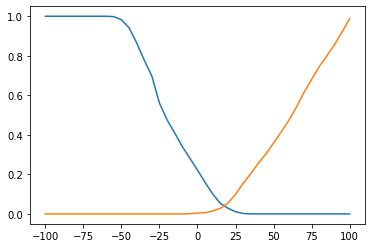

In [40]:
plt.plot(threslist, far)
plt.plot(threslist, frr)
plt.show()

In [41]:
min = 10000
for i in range(40):
    if abs(far[i] - frr[i]) < min:
        min = abs(far[i] - frr[i])
        index = i
print(index)
print(far[index])

23
0.05366666666666667


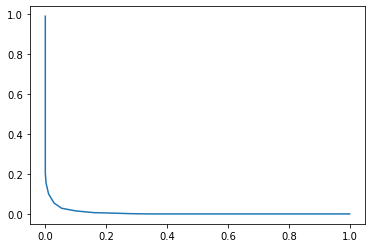

In [42]:
plt.plot(far, frr)
plt.show()

In [43]:
authentic = [[] for _ in range(len(SID_weight))]
for i in range(len(SID_weight)):
    for j in range(50):
        for k in range(50):
            img_weight = weight.T[j+i*50]
            ori_weight = weight.T[k+i*50]
            dist1 = LA.norm(img_weight)
            dist2 = LA.norm(ori_weight)
            cosine_similiarity = np.dot(img_weight, ori_weight)/(dist1 * dist2)
            authentic[i].append(cosine_similiarity)
np_authentic = np.array(authentic)

In [44]:
imposter = [[] for _ in range(len(SID_weight))]
for i in range(len(SID_weight)):
    for j in range(50):
        for k in range(len(SID_weight)):
            for a in range(50):
                if i != k:
                    img_weight = weight.T[j+i*50]
                    ori_weight = weight.T[a+k*50]
                    dist1 = LA.norm(img_weight)
                    dist2 = LA.norm(ori_weight)
                    cosine_similiarity = np.dot(img_weight, ori_weight)/(dist1 * dist2)
                    imposter[i].append(cosine_similiarity)
np_imposter = np.array(imposter)

In [45]:
np_imposter

array([[-0.33957415, -0.31936712, -0.3231209 , ..., -0.39097616,
        -0.34172854, -0.41460847],
       [-0.33957415, -0.32188174, -0.27968748, ..., -0.18629347,
        -0.22656634, -0.24380047],
       [-0.46180589, -0.44213557, -0.28254217, ...,  0.1300462 ,
         0.13937831,  0.0771536 ],
       [-0.39941104, -0.38329376, -0.369976  , ...,  0.08403516,
         0.00846618,  0.0771536 ]])

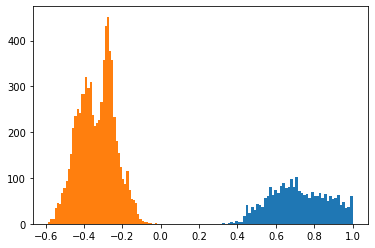

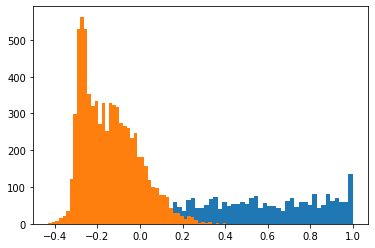

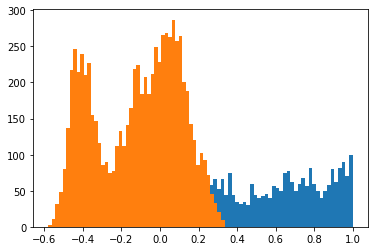

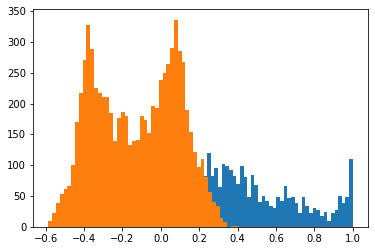

In [46]:
for i in range(len(SID_weight)):
    plt.hist(np_authentic[i], bins=50)
    plt.hist(np_imposter[i], bins=50)
    plt.show()

In [47]:
print(np_authentic.mean(), np_authentic.std())

0.5992496892143433 0.2499448559359725


In [48]:
print(np_imposter.mean(),np_imposter.std())

-0.1793967008696897 0.1949991049704017


In [49]:
img_weight.shape

(25,)

In [50]:
new_img

array([42, 40, 39, ..., 46, 43, 41], dtype=uint8)

# mean_face? eigen_face?

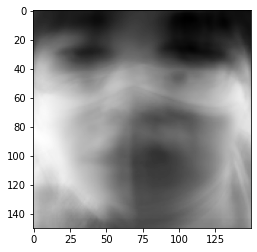

In [51]:
plt.imshow(mean_face.reshape(150, 150), cmap='gray')

<ipython-input-52-a371221145f9>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


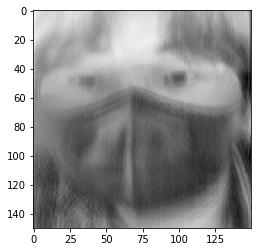

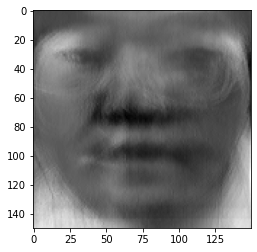

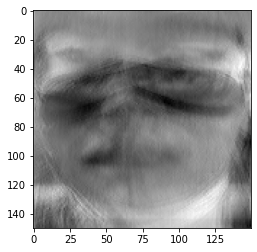

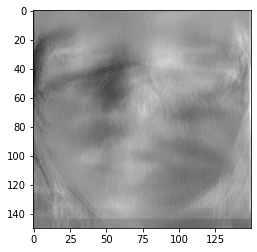

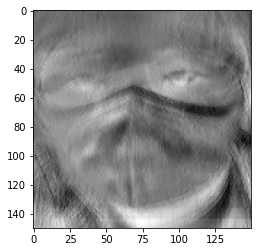

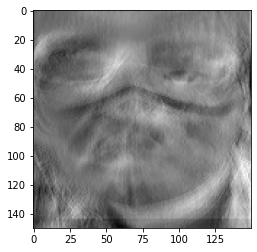

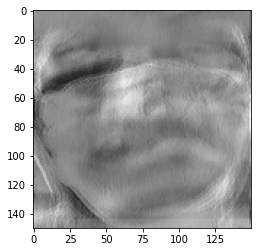

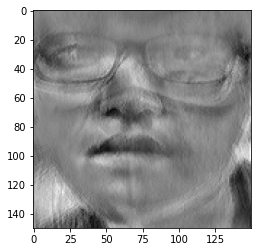

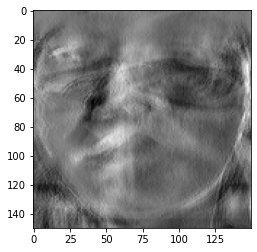

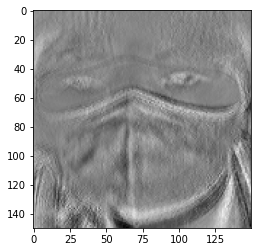

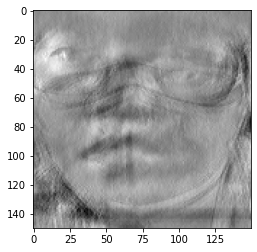

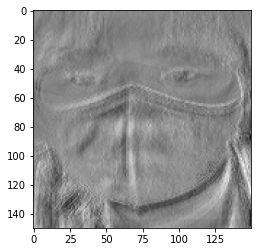

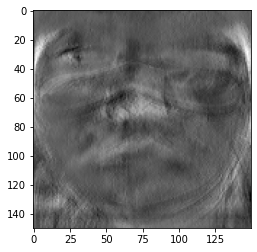

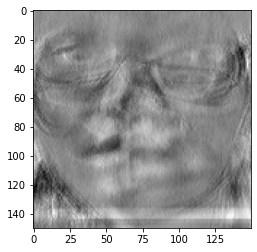

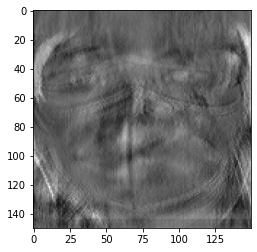

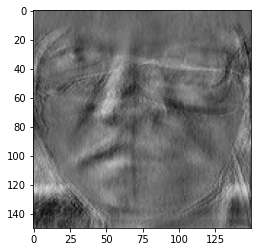

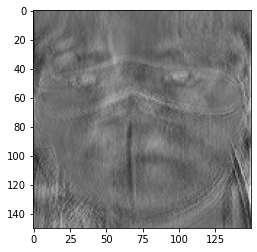

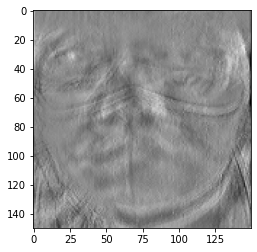

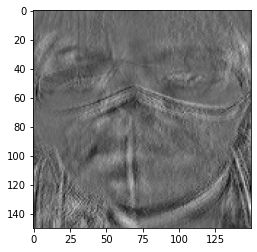

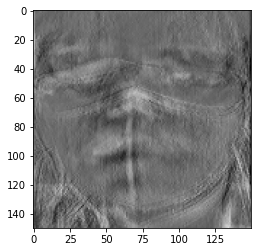

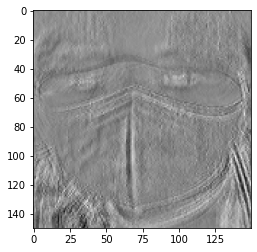

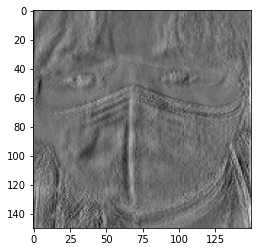

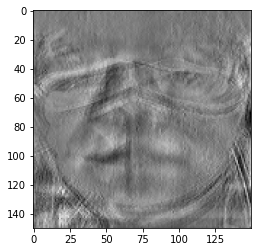

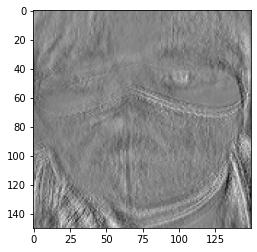

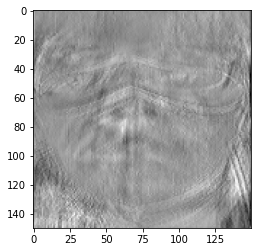

In [52]:
for i in range(eigenvector.shape[1]):
    plt.figure()
    plt.imshow(eigenvector[:,i].reshape(150, 150),  cmap='gray')

In [53]:
# 새로운 이미지일 때 이미지 재건
face1 = eigenvector@ img_weight.T + mean_face
plt.figure()
plt.imshow(face1.reshape(150, 150), cmap='gray')

ValueError: cannot reshape array of size 506250000 into shape (150,150)

<Figure size 432x288 with 0 Axes>

In [ ]:
eigenvector.shape

In [ ]:
# weight 값 가지고 이미지 재건
face1 = eigenvector@ weight[:, 199] + mean_face.reshape(-1)
plt.figure()
plt.imshow(face1.reshape(150, 150), cmap='gray')